Note: univariate, not multivariate

# CHRONOS Toy

installation (move to docker)

In [1]:
#! pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [1]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
from dvats.all import *

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib.


Octave is ready <oct2py.core.Oct2Py object at 0x7fee0290eaa0>

















## Load Model

In [2]:
timer = dvats.utils.Time()

In [3]:
timer.start()
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)
timer.end()

1727279770.0124426

In [5]:
timer.show()

[] Start: 1726827926.8767626 | End: 1726827927.8919077 | Duration: 1.0151450634002686 seconds


1.0151450634002686

## Load Dataset
> Esto debería hacerse ejecutandose 01, usando W&B etc

In [4]:
#| export
verbose                       = 1  
show_plots                    = False
reset_kernel                  = False
pre_configured_case           = True 
case_id                       = 7 
frequency_factor              = 1
frequency_factor_change_alias = True 
cuda_device                   = 0

In [5]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

In [6]:
base_path = Path.home()

In [7]:
import dvats.config as cfg_

In [8]:
#| export
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)

Pre configured case id: 7
Selecting  stumpy_toy_0
missing_values_constant: None
normalize_training: False
use_wandb: True
artifact_name: PulsusParadoxus-SP02 -> toy
wandb_artifacts_path: ./data/wandb_artifacts
freq: 1s
date_format: %Y-%m-%d %H:%M:%S
time_col: None
data_cols: [0] -> []
date_offset: None
missing_values_technique: None
range_training: None
resampling_freq: None
joining_train_test: False
test_split: None
csv_config: {'header': None} -> {}
range_testing: None
start_date: None
data_fpath: ~/data/PulsusParadoxusSP02_30_10000.csv -> ~/data/toy.csv
artifact_name: toy
csv_config: {}
data_cols: []
data_fpath: ~/data/toy.csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1s
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: None
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


In [9]:
#| export
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')

In [10]:
#| export
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if verbose > 0: display(df.head())

,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


In [11]:
#| export
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: print(df.index.freq)

<Second>


In [12]:
#| export
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df.columns)}')

Num. variables: 3


In [13]:
df.head()

,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [17]:
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

In [14]:
#| export
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

In [15]:
#| export
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


In [20]:
df.shape

(550, 3)

## Forecast: predict T1

In [48]:
pred_len    = 30
num_samples = 100

In [49]:
timer.start()
forecast_toy = pipeline.predict(
    context=torch.tensor(df["T1"]),
    prediction_length=pred_len,
    num_samples=num_samples,
)
timer.end()
timer.show()

[] Start: 1726828792.35491 | End: 1726828792.6975334 | Duration: 0.3426234722137451 seconds


0.3426234722137451

## Plot prediction

In [50]:
forecast_index = pd.date_range(start=df.index[-1], periods=pred_len+1, freq=df.index.freq)[1:]

In [51]:
low, median, high = np.quantile(forecast_toy[0].numpy(), [0.1, 0.5, 0.9], axis=0)

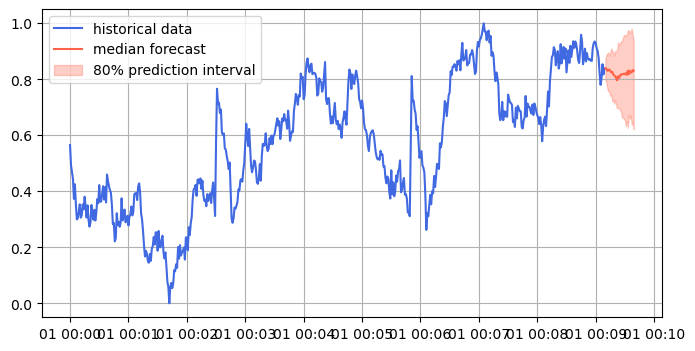

In [53]:
plt.figure(figsize=(8, 4))
plt.plot(df["T1"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

## Check the embeddings

Según los autores en el github, los embeddings se obtienen con pipeline.embed

In [54]:
? pipeline.embed

Signature:  pipeline.embed(context: Union[torch.Tensor, List[torch.Tensor]]) -> Tuple[torch.Tensor, Any]
Docstring:
Get encoder embeddings for the given time series.

Parameters
----------
context
    Input series. This is either a 1D tensor, or a list
    of 1D tensors, or a 2D tensor whose first dimension
    is batch. In the latter case, use left-padding with
    ``torch.nan`` to align series of different lengths.

Returns
-------
embeddings, tokenizer_state
    A tuple of two tensors: the encoder embeddings and the tokenizer_state,
    e.g., the scale of the time series in the case of mean scaling.
    The encoder embeddings are shaped (batch_size, context_length, d_model)
    or (batch_size, context_length + 1, d_model), where context_length
    is the size of the context along the time axis if a 2D tensor was provided
    or the length of the longest time series, if a list of 1D tensors was
    provided, and the extra 1 is for EOS.
File:      ~/.local/lib/python3.10/site-packages

In [55]:
context = torch.tensor(df["T1"])
embeddings, tokenizer_state = pipeline.embed(context)

In [57]:
len(context)

550

In [56]:
embeddings.shape

torch.Size([1, 513, 512])

Los embeddings no tiene el shape adecuado, el segundo valor debería ser 550

In [65]:
embs = embeddings.to(torch.float32).numpy()

Ángel habla de que los embeddings se crean para cada palabra
Entiendo que para nosotros una palabra es un patch de la serie temporal
Si tenemos (que no cuadra) tamaño batch size x n samples x dimension del modelo 
entiendo que nos interesa quitarnos dimension del modelo con una media basica

Además, MVP sacaba los embeddings como 

In [66]:
embs = embs.mean(axis = 2).T
embs.shape

(513, 1)

In [68]:
550 - pred_len

520

In [67]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 10
GPU | Used mem: 24
GPU | Memory Usage: [████████------------] 42%
-- cuml.UMAP -- False
GPU | Used mem: 10
GPU | Used mem: 24
GPU | Memory Usage: [████████------------] 42%


In [69]:
import hdbscan
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

In [ ]:
prjs_plt = plot_projections(prjs, umap_params)

[ 6 -1 33 30 15  2 12  8 28  9 20 27 21  4 25 18  7 14  0 22 11 31 29 23
 17 10 19  5  3 16  1 32 26 24 13]


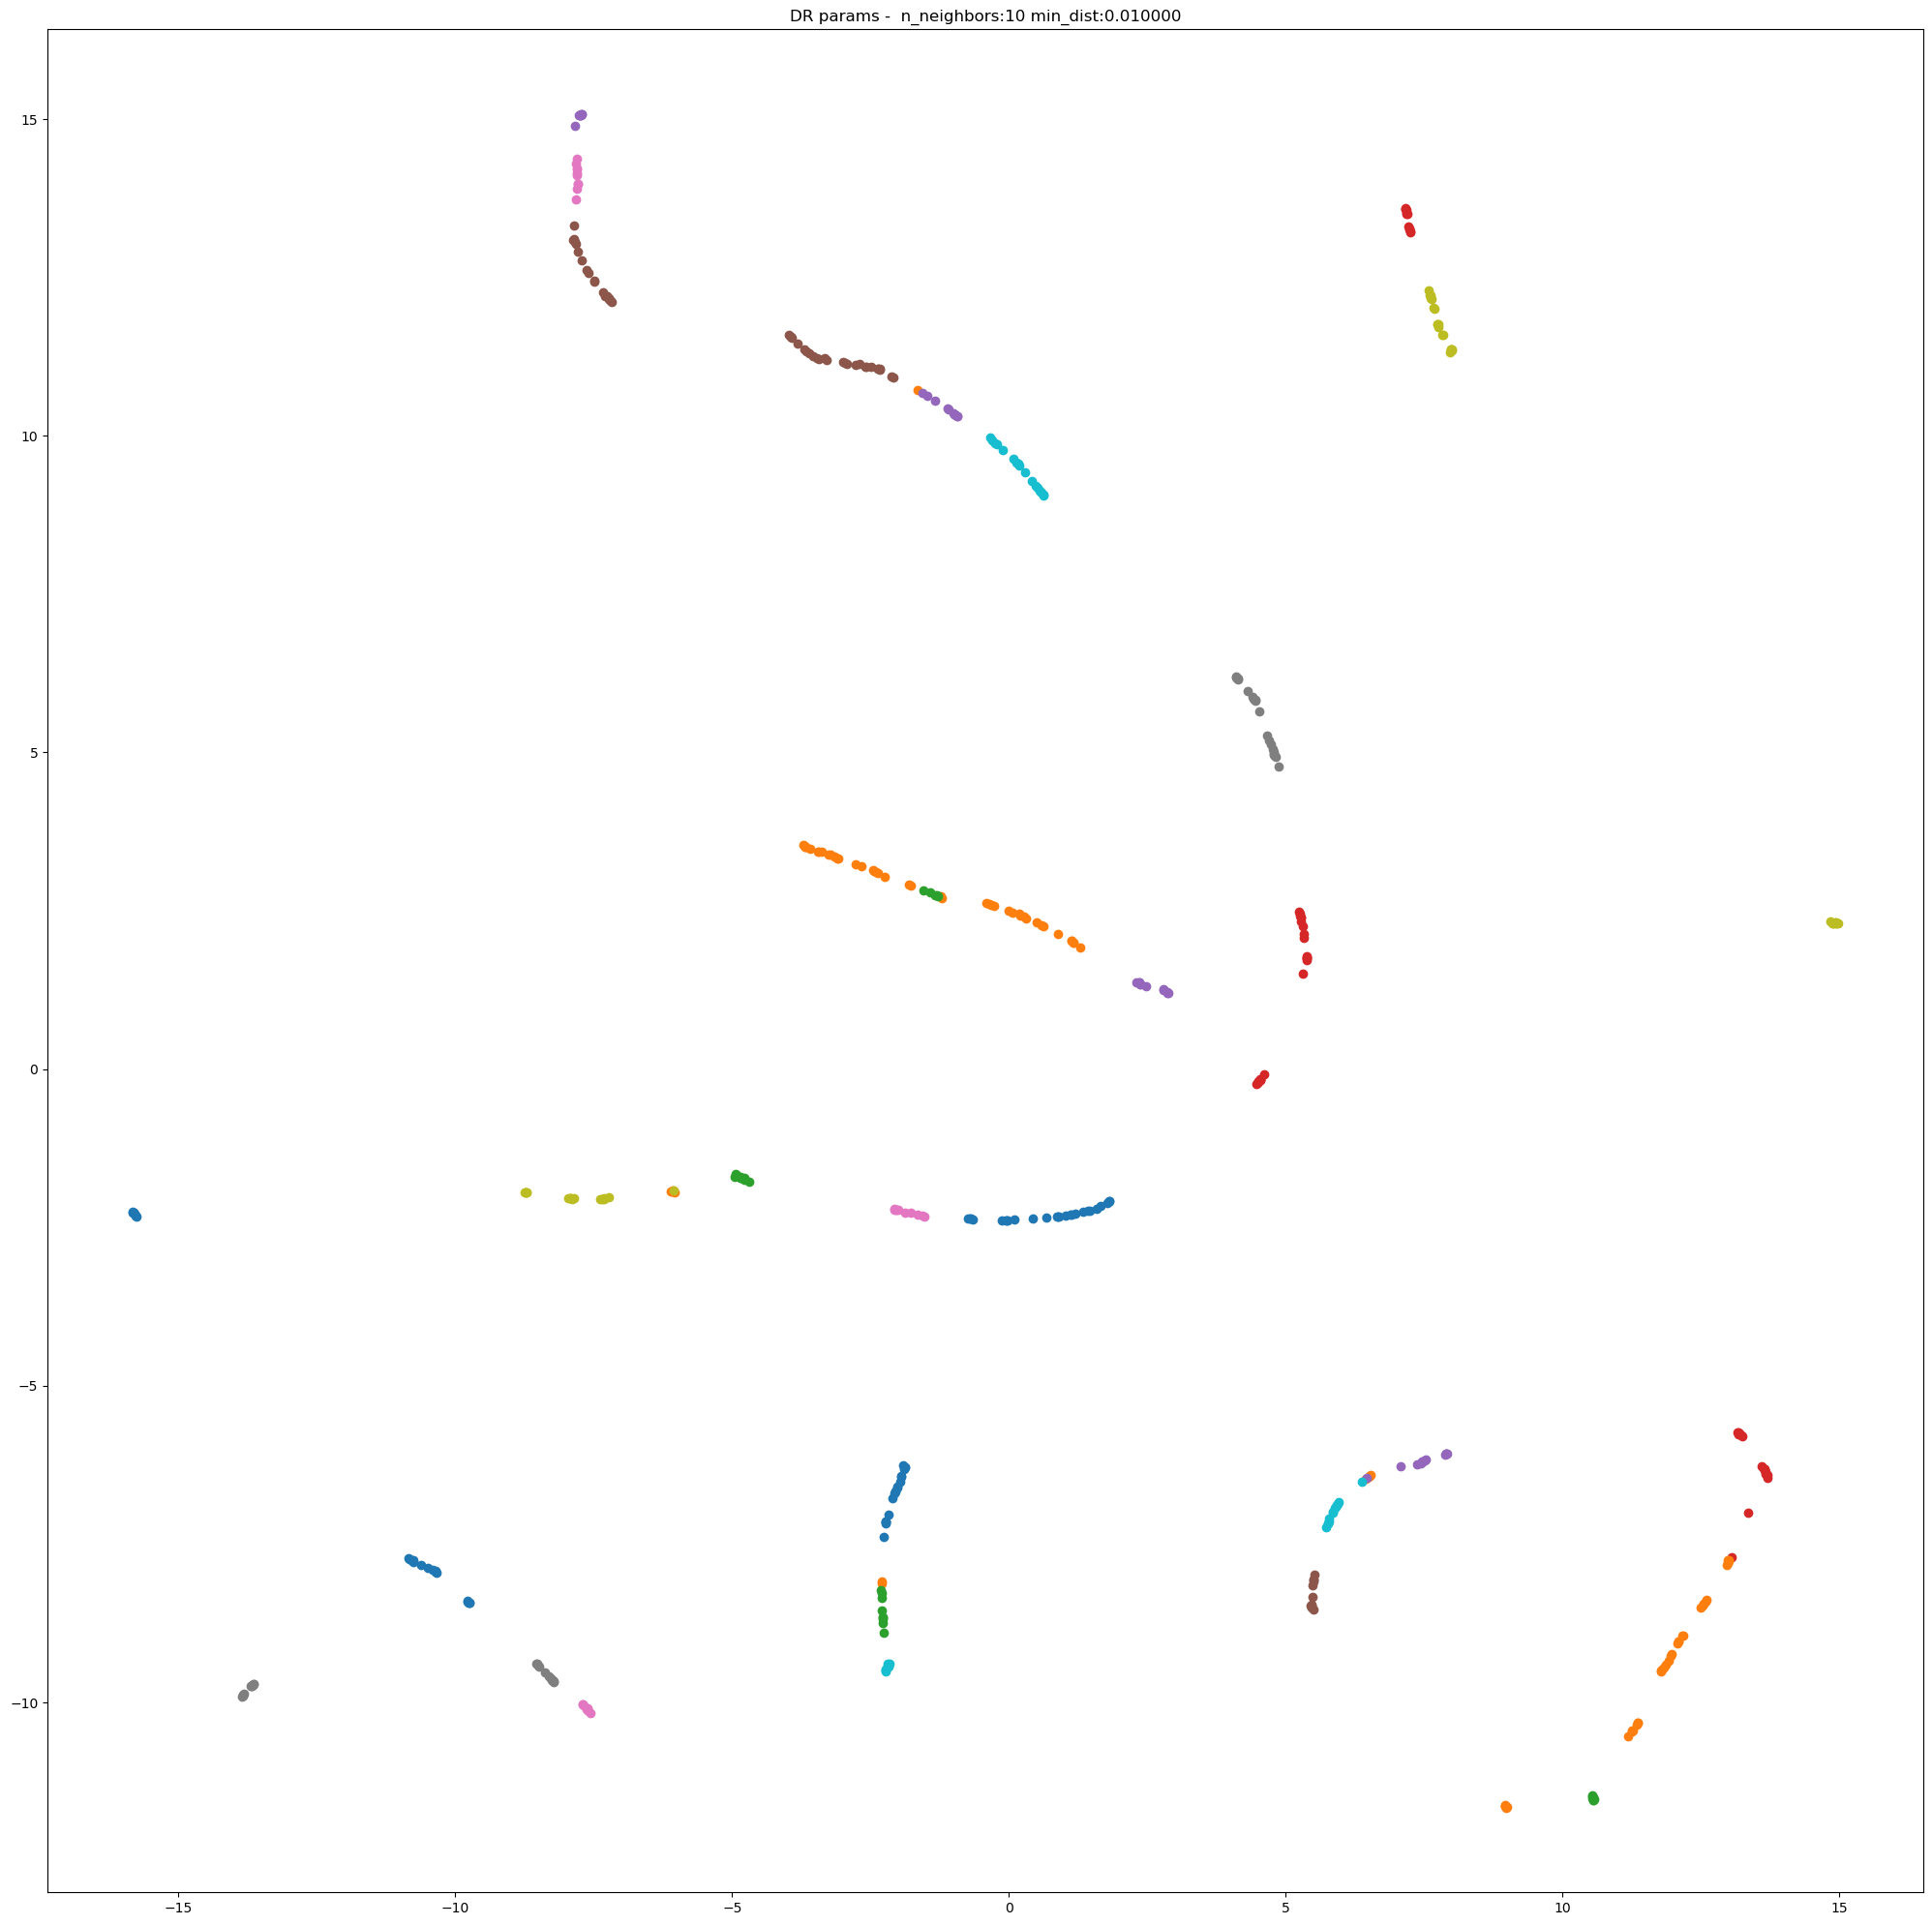

In [70]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

¿Qué es batch size? 
¿Qué es cada punto?
¿Cómo le cuento a R la relación entre cada ventana de la serie temporal y el punto del embedding?
¿Cómo sé qué patchs ha generado el modelo? 

# Multivariate

### Forecast

In [16]:
pred_len    = 30
num_samples = 20

In [17]:
timer.start()
forecast_toy = pipeline.predict(
    context=torch.tensor([df["T1"], df["T2"], df["T3"]]),
    prediction_length=pred_len,
    num_samples=num_samples,
)
timer.end()
timer.show()

[] Start: 1727279784.8742354 | End: 1727279786.2486012 | Duration: 1.3743658065795898 seconds


1.3743658065795898

In [213]:
df.shape

(550, 3)

In [212]:
forecast_toy.shape

torch.Size([3, 20, 30])

 ### Plot predictions

In [18]:
def get_forecast_index(df, pred_len):
    return pd.date_range(start=df.index[-1], periods=pred_len+1, freq=df.index.freq)[1:]
def plot_channel_prediction(
    df,
    prediction,
    forecast_index, 
    n_channel,
    channel,
    figsize = (8,4)
): 
    low, median, high = np.quantile(prediction[3-n_channel-1].numpy(), [0.1, 0.5, 0.9], axis=0)
    plt.figure(figsize=figsize)
    plt.plot(df[channel], color="royalblue", label="historical data " + channel)
    plt.plot(forecast_index, median, color="tomato", label="median forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
    plt.legend()
    plt.grid()
    plt.show()
    
    
def plot_channels_prediction(df, prediction, pred_len, figsize = (8,4)):
    forecast_index = get_forecast_index(df, pred_len)
    n_channel = -1
    for c in df.columns:
        n_channel += 1
        plot_channel_prediction(
            df = df, 
            prediction = prediction, 
            forecast_index = forecast_index, 
            n_channel = n_channel, 
            channel = c,
            figsize = figsize
        )

#### Prueba previa con T1

A lo bruto

In [142]:
df.columns[2]

'T1'

In [19]:
forecast_toy.shape
#n_channels x n_samples x pred_len

torch.Size([3, 20, 30])

In [20]:
n_channel = 2 
channel = df.columns[n_channel]
forecast_index = get_forecast_index(df, pred_len)

In [163]:
low, median, high = np.quantile(forecast_toy[3-n_channel-1].numpy(), [0.1, 0.5, 0.9], axis=0)

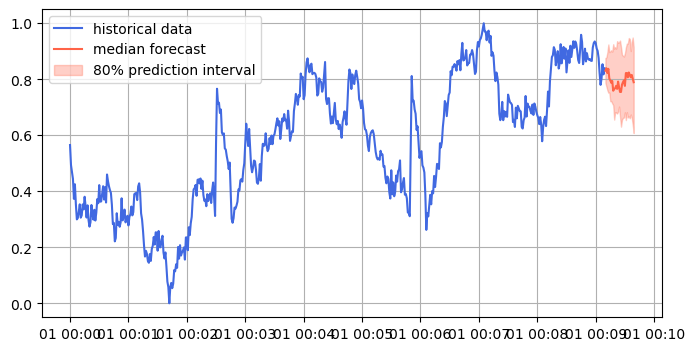

In [164]:
plt.figure(figsize=(8, 4))
plt.plot(df[channel], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

Con la función

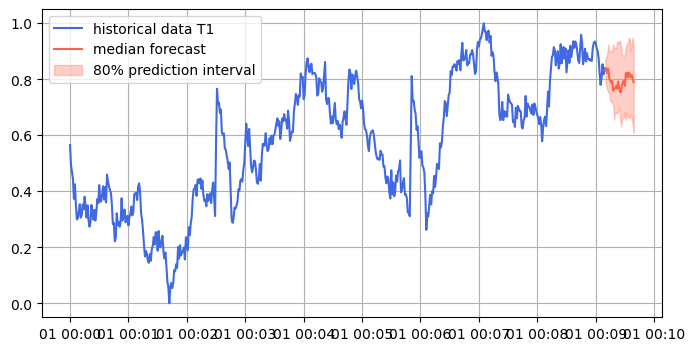

In [171]:
n_channel = 2
plot_channel_prediction(
    df = df,
    prediction = forecast_toy,
    forecast_index = forecast_index, 
    n_channel = n_channel,
    channel = df.columns[n_channel],
    figsize = (8,4)
)
    

#### Plot de las 3 variables

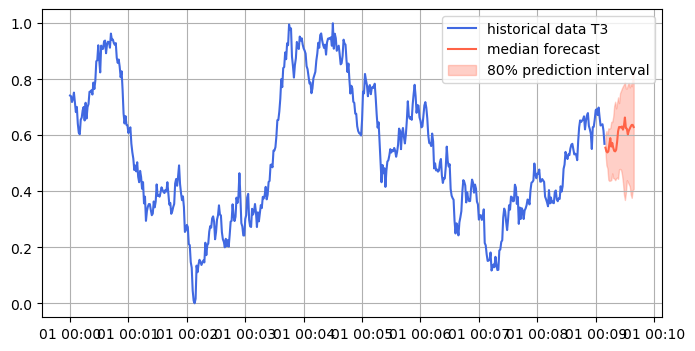

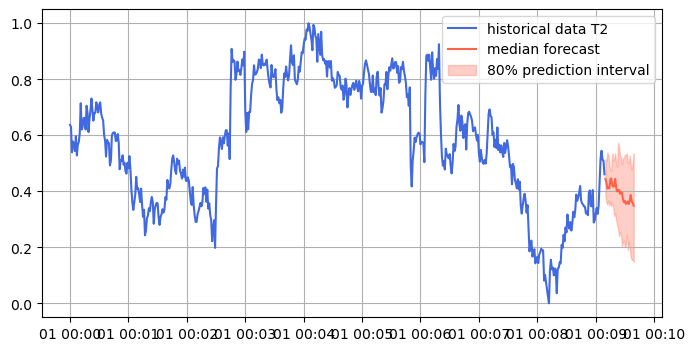

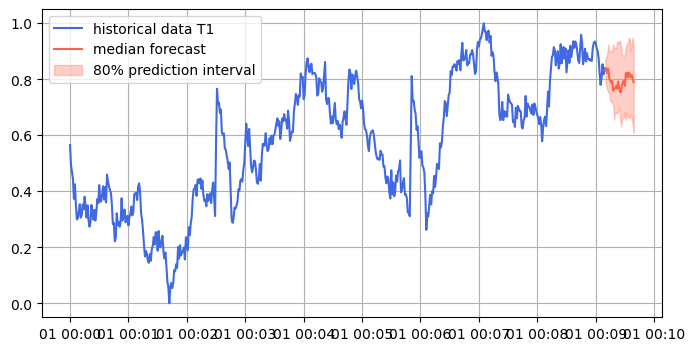

In [173]:
plot_channels_prediction(df, forecast_toy, pred_len)

DISCLAIMER!
Por qué el orden de las variables en las predicciones es... ¿El contrario a la posición de las variables?
¿Dónde puedo ver realmente las posiciones?
¿Cómo lo reviso?
¿Cómo interpreto los embeddings?

**¿Y qué pasaría si en MVP directamente cambio el predictor que predice cada ventana por uno de estos? Va de la leche de rápido** *¿Tendría sentido?

### Embeddings

In [21]:
context = torch.tensor([df["T1"], df["T2"], df["T3"]])
context.shape

torch.Size([3, 550])

Este tampoco tiene el tamaño que dicen en la documentación... pero es el mismo tamaño => No es algo aleatorio. 

El primer número son las variables

En MVP sale 521x128x30 siendo 30 el tamaño de la ventana y 521 el tamaño total menos el de la ventana. Y se hace media sobre la segunda dimensión para obtener tamaño 521 x 128

Quiero entender que en este caso tenemos un embedding para cada predicción => No ha aprendido en conjunto y debe meter padding o algo a las ventanas

Parece que ya vendrían en 2 dimensiones y no 3 (por ventana) y que lo que tendría que hacer es cogerme los embeddings en la posición del canal que quiera analizar o hacer una media entre todas las variables. Hagamos esto último. 

In [214]:
?? pipeline.embed

Signature:  pipeline.embed(context: Union[torch.Tensor, List[torch.Tensor]]) -> Tuple[torch.Tensor, Any]
Source:   
    @torch.no_grad()
    def embed(
        self, context: Union[torch.Tensor, List[torch.Tensor]]
    ) -> Tuple[torch.Tensor, Any]:
        """
        Get encoder embeddings for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.

        Returns
        -------
        embeddings, tokenizer_state
            A tuple of two tensors: the encoder embeddings and the tokenizer_state,
            e.g., the scale of the time series in the case of mean scaling.
            The encoder embeddings are shaped (batch_size, context_length, d_model)
            or (batch_size, context_length + 1, d_model)

In [24]:
hash_code = str(hash(pickle.dumps(pipeline)))

AttributeError: Can't pickle local object 'add_hook_to_module.<locals>.new_forward'

In [22]:
def get_chronos_prj(pipeline, context, verbose = 0):
    embeddings, tokenizer_state = pipeline.embed(context)
    embs = embeddings.to(torch.float32).numpy()
    if verbose> 0: print(f"embs init: {embs.shape}")
    embs_red = embs.mean(axis = 0)
    if verbose > 0: print(f"embs after: {embs_red.shape}")
    prjs = get_UMAP_prjs(embs_red, cpu=False, **umap_params)
    if verbose > 0: print(f"prjs: {prjs.shape}")
    return embs, embs_red, prjs

In [23]:
embs_multi_, embs_multi, prjs_multi = get_chronos_prj(pipeline = pipeline, context = context, verbose = 1)

embs init: (3, 513, 512)
embs after: (513, 512)
GPU | Used mem: 10
GPU | Used mem: 24
GPU | Memory Usage: [████████------------] 42%
-- cuml.UMAP -- False
GPU | Used mem: 10
GPU | Used mem: 24
GPU | Memory Usage: [████████------------] 42%
prjs: (513, 2)


In [194]:
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs_multi)
clusters_labels = clusters.labels_

[ 2 -1  3  4  0  1]


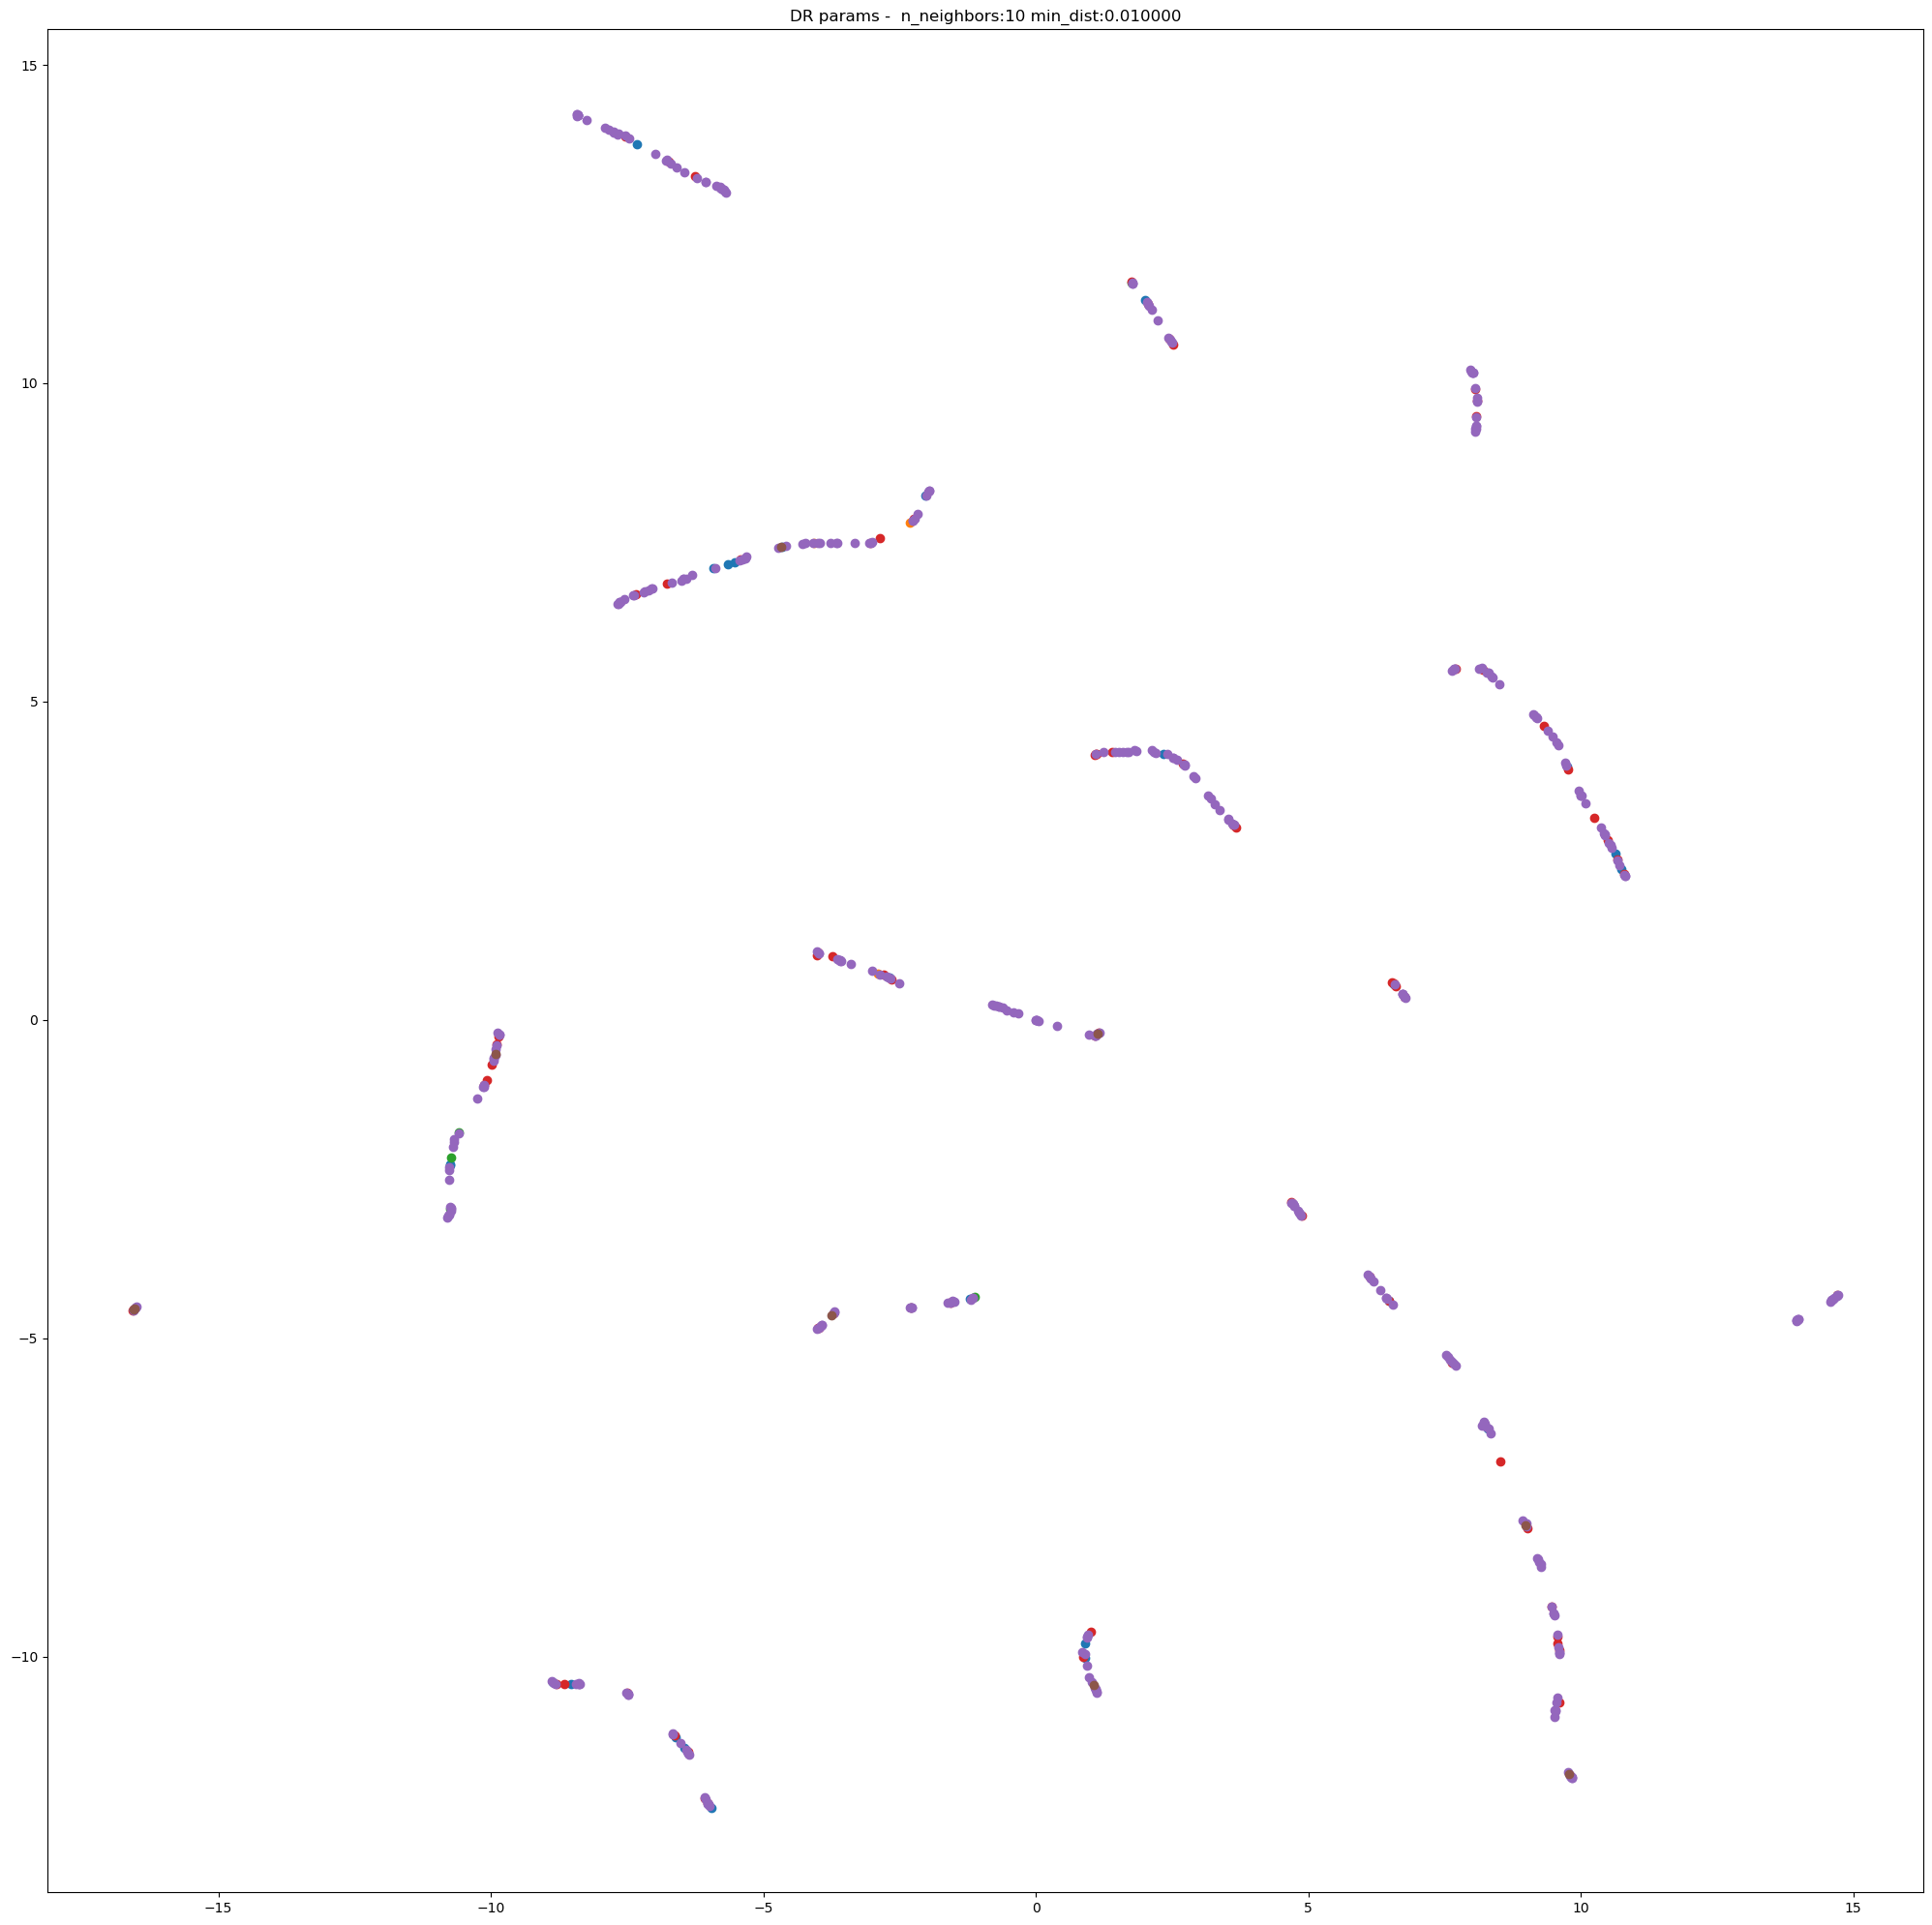

In [196]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

no difiere demasiado de la versión con 1 variable curiosamente :)

In [202]:
context.shape

torch.Size([3, 550])

In [203]:
? pipeline.embed

Signature:  pipeline.embed(context: Union[torch.Tensor, List[torch.Tensor]]) -> Tuple[torch.Tensor, Any]
Docstring:
Get encoder embeddings for the given time series.

Parameters
----------
context
    Input series. This is either a 1D tensor, or a list
    of 1D tensors, or a 2D tensor whose first dimension
    is batch. In the latter case, use left-padding with
    ``torch.nan`` to align series of different lengths.

Returns
-------
embeddings, tokenizer_state
    A tuple of two tensors: the encoder embeddings and the tokenizer_state,
    e.g., the scale of the time series in the case of mean scaling.
    The encoder embeddings are shaped (batch_size, context_length, d_model)
    or (batch_size, context_length + 1, d_model), where context_length
    is the size of the context along the time axis if a 2D tensor was provided
    or the length of the longest time series, if a list of 1D tensors was
    provided, and the extra 1 is for EOS.
File:      ~/.local/lib/python3.10/site-packages

In [208]:
embs_multi_.shape

(3, 513, 512)

In [209]:
550-513

37

In [210]:
pred_len

30